# Still Can't Decide Between Modules and Jupyter

## Libraries

In [9]:
#%% Libraries
# # Standard Libraries
from os import path
from pathlib import Path
from pprint import pprint
import asyncio as asyncio

# External Libraries
from IPython.display import display
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
from sklearn.linear_model import BayesianRidge as BR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error as mse
import statistics as stats
import matplotlib.pylab as mlt

# Custom Libraries
from modules.shared.custom import split, getPI

## Collection

In [10]:
# Just getting datasets
dataRoute = '../data/chembl/Additional_datasets/'
paths = ['data_CHEMBL313.csv', 'data_CHEMBL2637.csv', 'data_CHEMBL4124.csv']
dataSets = [pd.read_csv(dataRoute + path) for path in paths]
data = dataSets[0].sample(frac=1)
display(data)

,molecule_id,pXC50,b0001,b0002,b0003,b0004,b0005,b0006,b0007,b0008,...,b1015,b1016,b1017,b1018,b1019,b1020,b1021,b1022,b1023,b1024
2995,CHEMBL53182,5.420,1,0,0,1,1,0,1,0,...,1,0,0,1,1,0,0,0,0,0
3283,CHEMBL603692,5.287,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2213,CHEMBL353843,7.200,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
944,CHEMBL190173,6.084,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
342,CHEMBL129433,9.252,1,1,1,1,1,1,1,0,...,0,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,CHEMBL64965,5.126,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
544,CHEMBL152254,7.338,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
843,CHEMBL180182,7.500,1,1,1,0,1,0,1,0,...,0,1,1,0,0,0,0,0,0,0
153,CHEMBL1159861,6.000,1,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [12]:
def reduceTree(std: np.ndarray, X_unknown: pd.DataFrame, r: int):
    tree = KDTree(X_unknown.values)
    indicies = tree.query_ball_point(np.array(X_unknown), r, workers=-1)
    sdev = [std[i] for i in indicies]
    sdevMax = [max(s) for s in sdev]
    return np.where(sdevMax == std)[0]

async def getPredictions(m: object, X_known: pd.DataFrame, Y_known: pd.DataFrame, X_unknown: pd.DataFrame):
    model = m.fit(X_known, Y_known)
    return model.predict(X_unknown)

In [13]:
class Models:
    def __init__(self, m):
        self.models = m
    def fit(self, *args):
        self.trainedModels = [m.fit(*args) for m in self.models]
    def predict(self, *args):
        return np.mean([m.predict(*args) for m in self.trainedModels])

def validate(y_true, y_false):
    return mse(y_true, y_false, sample_weight=y_true)

## Models and Basics Set-up

In [11]:
# Splitting up the data
X_known, Y_known, X_unknown, Y_unknown, X_test, Y_test = split(data, 160)

# Each testing stage can test 160 cases and up to 2000 samples will be tested
testSize = 160
maxSamples = len(Y_unknown)

# models to be used and pre-defining variables
models = [BR(), KNN(), RFR()]
predicitions: list
scores: list
smartScores: list
tree: KDTree

## Assessment

## Script

In [14]:
r = 5
runningScore = []
for i in range(0, maxSamples, testSize):
    print(f'\r{i}.0 out of {maxSamples}', end="")
    predictions = [await getPredictions(m, X_known, Y_known, X_unknown) for m in models]
    np_predictions = np.array(predictions)
    stdd = np.std(np_predictions, axis=0, ddof=1)
    index = []
    print(f'\r{i}.2 out of {maxSamples}', end="")

    index = reduceTree(stdd, X_unknown, r)
    if len(index)>min(160, len(X_unknown)):
        print(len(index))
        index = index[:min(160, len(X_unknown))]
    else:
        semi = np.argpartition(stdd, -min(len(X_unknown), testSize))[-min(len(X_unknown), testSize):]

        semi = semi[np.invert(np.isin(semi, index))]
        index = np.array(list(index) + list((semi[np.argsort(stdd[semi])])[len(index)-min(len(X_unknown), testSize):]))
        
    index2 = X_unknown.iloc[index[:min(testSize, len(X_unknown))]].index
    score = validate(np.mean([await getPredictions(m, X_known, Y_known, X_test) for m in models], axis=0), Y_test)
    runningScore.append(score)
    X_known, Y_known, X_unknown, Y_unknown = getPI((X_known, Y_known), (X_unknown, Y_unknown), index2[:testSize])   



2880.2 out of 3014

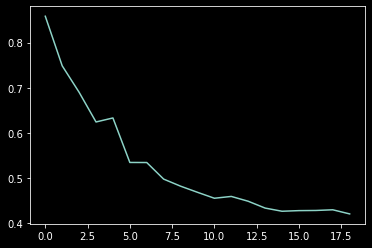

In [16]:
mlt.plot(runningScore)